In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import random

In [2]:
%load_ext autoreload
%autoreload 2
from base import utils, datahandler, prediction_models, evaluation

In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

In [4]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

In [5]:
some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:20]}

In [17]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features,
                                      label_features=['EW', 'NS'],
                                      train_val_split=0.85, stride=1,
                                      input_history_steps=8, input_future_steps=8, seed=69)

=========================Creating Dataset=========================
Seed: 69
nTrain: 212 nVal: 38 (0.85)
Padding: True
Scaling: True
Labels: ['EW_encoded', 'NS_encoded']
=========================Finished Dataset=========================


In [18]:
train_combined, val_combined = ds_gen.get_datasets(1024, label_features=['EW', 'NS'], shuffle=True)
print(train_combined.element_spec)


(TensorSpec(shape=(None, 16, 15), dtype=tf.float64, name=None), {'EW': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 16, 15)]             0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 11, 64)               5824      ['Input[0][0]']               
                                                                                                  
 flatten_2 (Flatten)         (None, 704)                  0         ['conv1d_4[0][0]']            
                                                                                                  
 dense_3 (Dense)             (None, 128)                  90240     ['flatten_2[0][0]']           
                                                                                            

c:\Code\ARCLab Challenge\splid-challenge\base\prediction_models.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


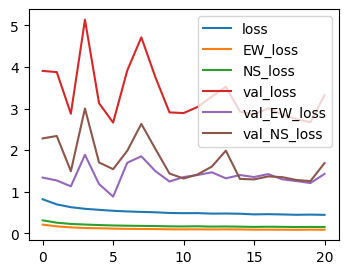

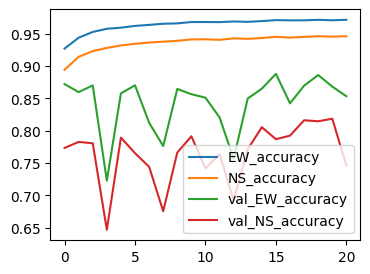

In [19]:
#dense_combined_model = prediction_models.Dense_NN(train_combined, dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_combined_model = prediction_models.CNN(train_combined, conv_layers=[[128,3],[128,3],[128,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_combined_model = prediction_models.Dense_NN(train_combined, dense_layers=[256,128,64], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[20000,0.8], seed=0)
dense_combined_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,6]], dense_layers=[128,64,32], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[25000,0.9], seed=0)


dense_combined_model.summary()
hist = dense_combined_model.fit(train_combined, val_ds=val_combined, target_metric='val_loss', epochs=150, verbose=1, plot_hist=False, callbacks=[], early_stopping=15)
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [20]:
def prepare_submission_df(ds, model, model_output_features, label_decoders, smoothing=False, smoothing_past_steps=3, smoothing_fut_steps=10):
    '''Prepare dataframes for submission based on models predictions. The output_labels need to be in the same order as they were when creating the dataset!'''
    assert(len(model_output_features) == len(label_decoders))
    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])
    
    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)

    preds = model.predict(inputs)
    for ft_idx, feature in enumerate(model_output_features):
        labels = np.concatenate([element[feature] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
        labels_decoded = label_decoders[ft_idx].inverse_transform(labels)
        preds_argmax = np.argmax(preds[ft_idx], axis=1) if len(model_output_features)>1 else np.argmax(preds, axis=1)
        preds_decoded = label_decoders[ft_idx].inverse_transform(preds_argmax)
        df[f'{feature}'] = labels_decoded
        df[f'Predicted_{feature}'] = preds_decoded
    if smoothing:
        df = utils.smooth_predictions(df, past_steps=smoothing_past_steps, fut_steps=smoothing_fut_steps)
    return df


In [27]:
def evaluate_submission_df(prepared_df, ground_truth):
    results = utils.convert_classifier_output(prepared_df).sort_values(['ObjectID']).reset_index(drop=True)
    evaluator = evaluation.NodeDetectionEvaluator(ground_truth, results)
    precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F2: {f2:.2f}')
    print(f'RMSE: {rmse:.4}')
    print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

In [22]:
ground_truth = pd.read_csv(challenge_data_dir / 'train_labels.csv')
ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.train_keys))].copy()
ground_truth_val = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.val_keys))].copy()

train_EW, val_EW = ds_gen.get_datasets(256, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)

In [25]:
df_train=prepare_submission_df(ds=train_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'],
                               label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder],
                               smoothing=True, smoothing_past_steps=3, smoothing_fut_steps=10)


# Dense result: F2 0.49/0.32 (t/v)
# Dense result(w/ future): F2 0.46/0.45 (t/v) (256/128/54)

# Conv result (no future): F2 0.53/0.37
# Conv result (w/ future): F2 0.51/0.38

14433/14433 [==============================] - 32s 2ms/step


Smoothing: 100%|██████████| 212/212 [03:53<00:00,  1.10s/it]


ValueError: too many values to unpack (expected 4)

In [28]:
evaluate_submission_df(df_train, ground_truth_train)


Precision: 0.12
Recall: 0.56
F2: 0.32
RMSE: 1.626
TP: 492 FP: 3764 FN: 393


In [ ]:
train_EW, val_EW = ds_gen.get_datasets(256, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_val=prepare_submission_df(ds=val_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'],
                                label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder],
                               smoothing=True, smoothing_past_steps=3, smoothing_fut_steps=10)
evaluate_submission_df(df_val, ground_truth_val)


68/68 [==============================] - 0s 828us/step


Smoothing: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

Precision: 0.20
Recall: 0.40
F2: 0.33
RMSE: 4.24
